[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yeticheese/NMA_Impact_Scholars_Steinmetz/blob/master/notebooks/EDA_PSTH_Analysis.ipynb)


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, requests
import sys
from scipy.stats import ttest_rel, wilcoxon, norm, binom, chi2
import scipy.stats as stats
from scipy.signal import argrelmax
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from src.generate_psth_df import process_data
import seaborn as sns


### Declaring data directory variables

In [68]:
# Local
root = r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz"
sys.path.append(root)

#Change working directory
cwd = os.chdir(root)

# @title Data retrieval
data_directory = os.path.join(root,'data','spikeAndBehavioralData') # Dowload https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406 to this directory
dataset_dir = os.path.join(root,'data','concat_df.pkl')
figures = os.path.join(root, 'figures')
print(figures)
print(dataset_dir)
print(data_directory)

#Check the current working directory matches root
print(os.getcwd())

C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\figures
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\concat_df.pkl
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\spikeAndBehavioralData
C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz


### Loading the binned Dataset

In [3]:
# Step 2: Extract and Visualize Data from alldat.
# Load Data
fnames = []
for j in range(1,4,1):
  fnames.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fnames[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fnames[j], "wb") as fid:
          fid.write(r.content)

# Function to load data from npz files
def load_data(filenames):
    alldat = np.array([])
    for filename in filenames:
        data = np.load(filename, allow_pickle=True)['dat']
        alldat = np.hstack((alldat, data))
    return alldat

# Download data if not already present
# download_data(urls, filenames)

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

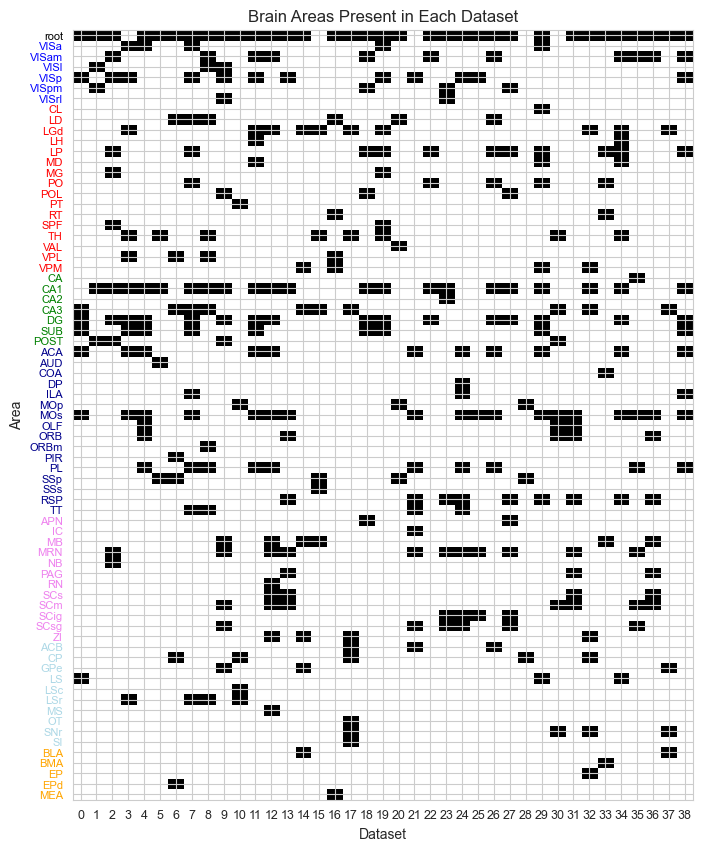

In [4]:
# Function to plot brain areas present in each dataset
def plot_brain_areas(data):
    # Brain Region Information
    regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
    region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
    brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                    ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],  # thalamus
                    ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                    ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],  # non-visual cortex
                    ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                    ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                    ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                    ]

    # Assign Each Area an Index
    area_to_index = dict(root=0)
    counter = 1
    for group in brain_groups:
        for area in group:
            area_to_index[area] = counter
            counter += 1

    # Determine Areas in Each Dataset
    areas_by_dataset = np.zeros((counter, len(data)), dtype=bool)
    for j, d in enumerate(data):
        for area in np.unique(d['brain_area']):
            i = area_to_index.get(area, -1)
            if i != -1:
                areas_by_dataset[i, j] = True

    # Visualize the Presence of Neurons in Different Regions Across Datasets
    plt.figure(figsize=(8, 10))
    plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

    # Label the Axes
    plt.xlabel("Dataset")
    plt.ylabel("Area")

    # Add Tick Labels
    yticklabels = ["root"]
    for group in brain_groups:
        yticklabels.extend(group)
    plt.yticks(np.arange(counter), yticklabels, fontsize=8)
    plt.xticks(np.arange(len(data)), fontsize=9)
 
    ytickobjs = plt.gca().get_yticklabels()
    ytickobjs[0].set_color("black")
    counter = 1
    for group, color in zip(brain_groups, region_colors):
        for area in group:
            ytickobjs[counter].set_color(color)
            counter += 1

    plt.title("Brain Areas Present in Each Dataset")
    plt.grid(True)
    plt.show()

# Plot brain areas present in each dataset
alldat = load_data(fnames)
plot_brain_areas(alldat)

### Sorting and generating brain region labels

In [5]:
brain_groups = {'visual_cortex':["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], 
                'thalamus': ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], 
                'hippocampal': ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  
                'non_visual_cortex': ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"], 
                'midbrain': ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], 
                'basal_ganglia': ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], 
                'cortical_subplate': ["BLA", "BMA", "EP", "EPd", "MEA"]}

In [6]:
brain_areas = []
for vals in brain_groups.values():
    brain_areas += vals
print(brain_areas)

['VISa', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl', 'CL', 'LD', 'LGd', 'LH', 'LP', 'MD', 'MG', 'PO', 'POL', 'PT', 'RT', 'SPF', 'TH', 'VAL', 'VPL', 'VPM', 'CA', 'CA1', 'CA2', 'CA3', 'DG', 'SUB', 'POST', 'ACA', 'AUD', 'COA', 'DP', 'ILA', 'MOp', 'MOs', 'OLF', 'ORB', 'ORBm', 'PIR', 'PL', 'SSp', 'SSs', 'RSP', 'TT', 'APN', 'IC', 'MB', 'MRN', 'NB', 'PAG', 'RN', 'SCs', 'SCm', 'SCig', 'SCsg', 'ZI', 'ACB', 'CP', 'GPe', 'LS', 'LSc', 'LSr', 'MS', 'OT', 'SNr', 'SI', 'BLA', 'BMA', 'EP', 'EPd', 'MEA']


### Construct the dataset using pandas

In [7]:
concat_df = pd.DataFrame()
if os.path.exists(dataset_dir):
    print("Dataset already exists. Skipping.")
    #Load the dataset
    concat_df = pd.read_pickle(dataset_dir)
else:
    concat_df = process_data(alldat)
    print("Created dataset.")
    concat_df.to_pickle(dataset_dir)
    print('Dataset_saved to location."')

Dataset already exists. Skipping.


In [8]:
def str_to_array(string:str) -> np.ndarray:
    array = np.array(string.strip('[]').split()).astype(np.float64)
    return array


In [9]:
concat_df.head()

,brain_area,ap,dv,lr,neuron_id,response,response_time,contrast_right,contrast_left,feedback_time,...,probe,template_waveforms,waveform_duration,peak_to_trough_duration,phy_annotation,spks,contrast_pair,trial_outcome,neuron_type,stimulus_side
0,ACA,4090.0,2445.4,5012.4,0,1.0,1.150204,0.0,1.0,1.186819,...,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19.0,0.6,3.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1.0, 0.0)",left_reward,excitatory,ipsilateral
1,ACA,4090.0,2445.4,5012.4,0,-1.0,1.399503,0.5,0.0,1.437623,...,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19.0,0.6,3.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0.5, 0.0)",right_reward,excitatory,contralateral
2,ACA,4090.0,2445.4,5012.4,0,1.0,0.949291,0.5,1.0,0.986016,...,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19.0,0.6,3.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1.0, 0.5)",left_reward,excitatory,ipsilateral
3,ACA,4090.0,2445.4,5012.4,0,0.0,2.266802,0.0,0.0,2.296436,...,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19.0,0.6,3.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0.0, 0.0)",nogo,excitatory,nogo
4,ACA,4090.0,2445.4,5012.4,0,1.0,0.816776,1.0,0.5,0.827613,...,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19.0,0.6,3.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1.0, 0.5)",right_penalty,excitatory,contralateral


### Create special functions to create a PSTH dataset

In [10]:
def calculate_psth(x):
    return np.mean(np.stack(x), axis=0)*100

In [11]:
def smooth_psth(psth, method='gaussian', **kwargs):
    """
    Smooth a Peri-Stimulus Time Histogram using various methods.

    Parameters:
    -----------
    psth : numpy.ndarray
        The raw PSTH data
    method : str
        Smoothing method ('gaussian', 'moving_average', or 'savgol')
    kwargs : dict
        Additional parameters specific to each method

    Returns:
    --------
    numpy.ndarray
        Smoothed PSTH data
    """

    if method == 'gaussian':
        # Gaussian smoothing
        sigma = kwargs.get('sigma', 2)
        return gaussian_filter(psth, sigma=sigma)

    elif method == 'moving_average':
        # Moving average smoothing
        window_size = kwargs.get('window_size', 5)
        kernel = np.ones(window_size) / window_size
        return np.convolve(psth, kernel, mode='same')

    elif method == 'savgol':
        # Savitzky-Golay filtering
        window_length = kwargs.get('window_length', 5)
        poly_order = kwargs.get('poly_order', 2)
        return savgol_filter(psth, window_length, poly_order)

    else:
        raise ValueError("Unknown smoothing method")

In [12]:
def latency_peak_response(x):
    smooth_x = smooth_psth(x,'gaussian')
    # Calculate first derivative
    first_derivative = np.diff(smooth_x)




    peaks = argrelmax(smooth_x, order=1)[0]

    latency = np.argmax(first_derivative)+1


    diff_peaks = peaks-latency
    max_peaks_bool = smooth_x[peaks] > 1.5

    try:
        peak_loc = peaks[(diff_peaks > 0) & max_peaks_bool][0]
        peak_val = smooth_x[peak_loc]

        return latency, peak_val, peak_loc
    except:
        return 0, 0, 0

### Grouping the dataset by keywords

In [13]:
trial_df = concat_df.groupby(['mouse_name','date_exp','brain_area','neuron_id','stimulus_side']).agg({'spks':[('trial_count_overall',lambda x: np.stack(x).shape[0])]})
if isinstance(trial_df.columns, pd.MultiIndex):
    trial_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in trial_df.columns]

In [14]:
def zscore_test(psth, baseline_mean, baseline_std, alpha =0.05):
    # Find maximum z-score in response window
    z_scored_psth = (psth-baseline_mean)/baseline_std
    max_zscore = latency_peak_response(z_scored_psth)[1]

    # Determine significance threshold from alpha
    z_threshold = stats.norm.ppf(1 - alpha/2)  # Two-tail

    # Calculate approximate p-value (two-tailed)

    p_value = 2 * (1 - norm.cdf(max_zscore))

    # Determine significance
    if max_zscore > 3:
        is_significant = 'strong'
    elif (max_zscore > z_threshold) & (max_zscore <=3):
        is_significant = 'moderate'
    elif (max_zscore > 1.65) & (max_zscore <= z_threshold):
        is_significant = 'weak'
    elif max_zscore <= 1.65:
        is_significant = 'insignificant'

    return is_significant, max_zscore, p_value


In [15]:
def t_test(x, alpha=0.05):
    """
    Performs paired t-test between baseline and response periods
    """
    trial_baseline = x[:, :50]
    trial_response = x[:, 50:80]
    # Use trial-by-trial firing rates
    # t_stat, p_value = stats.ttest_rel(trial_response_rates, trial_baseline_rates)

    # Alternative: average activity in each trial's baseline and response periods
    trial_baseline_means = np.mean(trial_baseline, axis=1)
    trial_response_means = np.mean(trial_response, axis=1)
    bin_t_stat, bin_p_value = ttest_rel(trial_response_means, trial_baseline_means)

    # Determine if response is significant
    is_significant = bin_p_value < alpha

    return is_significant, bin_p_value




In [16]:
def wilcoxon_test(x, alpha=0.05):
    """
    Performs Wilcoxon signed-rank test between baseline and response periods
    (Non-parametric alternative to paired t-test)
    """
    trial_baseline = x[:, :50]
    trial_response = x[:, 50:80]

    # Alternative: average activity in each trial's baseline and response periods
    trial_baseline_means = np.mean(trial_baseline, axis=1)
    trial_response_means = np.mean(trial_response, axis=1)
    bin_w_stat, bin_p_value = wilcoxon(trial_response_means, trial_baseline_means)

    # Determine if response is significant
    is_significant = bin_p_value < alpha

    return is_significant,bin_p_value, bin_w_stat


In [17]:
def compute_responsiveness_pvalues(df, n_resp_col='n_responsive', n_trial_col='n_trials', p_null=0.05, min_trials=5, normal_approx_threshold=30):
    """
    Compute p-values for neuron reliability using binomial tests.
    Automatically switches between exact binomial and normal approximation.

    Parameters:
        df: pandas.DataFrame
        n_resp_col: str, column with count of responsive trials
        n_trial_col: str, column with total number of trials
        p_null: float, null hypothesis responsiveness rate (default: 0.05)
        min_trials: int, minimum number of trials to include in analysis
        normal_approx_threshold: int, switch to normal approximation if n_trials >= this value

    Returns:
        df: original dataframe with a new 'p_value' column
    """

    n_responsive = df[n_resp_col].to_numpy()
    n_trials = df[n_trial_col].to_numpy()

    # Initialize p-values with NaNs
    p_values = np.full(len(df), np.nan)

    for i in range(len(df)):
        k = n_responsive[i]
        n = n_trials[i]

        if n < min_trials:
            # Not enough trials to evaluate reliability
            continue
        elif n >= normal_approx_threshold:
            # Use normal approximation
            p_hat = k / n
            se = np.sqrt(p_null * (1 - p_null) / n)
            z = (p_hat - p_null) / se
            p_values[i] = 1 - norm.cdf(z)  # one-sided test
        else:
            # Use exact binomial test
            p_values[i] = binom.sf(k - 1, n, p_null)  # P(X >= k)

    df['p_value'] = p_values
    return df

In [18]:
def combine_pvalues_fisher_safe(p_list):
    # Filter out NaNs
    clean_p = [p for p in p_list if not np.isnan(p)]

    # If no valid p-values, return NaN
    if len(clean_p) == 0:
        return np.nan

    stat = -2 * np.sum(np.log(clean_p))
    df = 2 * len(clean_p)
    combined_p = chi2.sf(stat, df)
    return combined_p

In [19]:
neuron_df = concat_df.groupby(['mouse_name','date_exp','brain_area','neuron_id','stimulus_side','contrast_right','trial_outcome']).agg({
    'spks': [
        ('stack', lambda x: np.stack(x)),
        ('psth', lambda x: calculate_psth(np.stack(x))),
        ('trial_count', lambda x: np.stack(x).shape[0]),
    ]
})
neuron_df= neuron_df.reset_index()
if isinstance(neuron_df.columns, pd.MultiIndex):
    neuron_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in neuron_df.columns]

neuron_df['neuron_id_str'] = neuron_df.apply(lambda row: f'{row.mouse_name}_{row.date_exp}_{row.brain_area}_{row.neuron_id}', axis=1)

neuron_df['baseline_avg'] = neuron_df.spks_stack.apply(lambda x: np.mean(x[:,:50], axis=(0,1))*100)
neuron_df['baseline_std'] = neuron_df.spks_stack.apply(lambda x: np.std(x[:,:50], axis=(0,1))*100)
neuron_df['normalized_psth'] = (neuron_df.spks_psth-neuron_df.baseline_avg)/neuron_df.baseline_std
neuron_df['diff_latency_response'] = neuron_df.normalized_psth.apply(lambda x: latency_peak_response(x)[0]*10)
neuron_df['diff_peak_val'] = neuron_df.normalized_psth.apply(lambda x: latency_peak_response(x)[1])
neuron_df['diff_peak_loc'] = neuron_df.normalized_psth.apply(lambda x: latency_peak_response(x)[2])

neuron_df['diff_latency_response'] -= 500
neuron_df = neuron_df.query('diff_latency_response > 0 & diff_latency_response <= 300')

neuron_df = neuron_df.merge(trial_df, on=['mouse_name','date_exp','brain_area','neuron_id','stimulus_side'], how='left')
neuron_df['trial_count_percent'] = (neuron_df.spks_trial_count/neuron_df.spks_trial_count_overall)*100
neuron_df = neuron_df.sort_values(by='diff_latency_response', ascending=True)

#Z-Score threshold Test
neuron_df['max_zscore'] = neuron_df.apply(lambda row: zscore_test(row.spks_psth,row.baseline_avg,row.baseline_std)[1],axis=1)
neuron_df['significance'] = neuron_df.apply(lambda row: zscore_test(row.spks_psth,row.baseline_avg,row.baseline_std)[0],axis=1)
neuron_df['p_val_zscore'] = neuron_df.apply(lambda row: zscore_test(row.spks_psth,row.baseline_avg,row.baseline_std)[2],axis=1)

# T-Test
neuron_df['t_test_significance'] = neuron_df.spks_stack.apply(lambda x: t_test(x)[0])
neuron_df['p_val_t_test'] = neuron_df.spks_stack.apply(lambda x: t_test(x)[1])

# Wilcoxon Test
neuron_df['wilcox_significance'] = neuron_df.spks_stack.apply(lambda x: t_test(x)[0])
neuron_df['p_val_wilcox'] = neuron_df.spks_stack.apply(lambda x: t_test(x)[1])

neuron_df['n_responsive'] = neuron_df.spks_stack.apply(lambda x: x.shape[0])


neuron_df['p_val_binom'] = compute_responsiveness_pvalues(neuron_df, n_resp_col='n_responsive', n_trial_col='spks_trial_count_overall')['p_value']
neuron_df = neuron_df.query('significance != "insignificant"')
neuron_df['combined_p_val'] = neuron_df.apply(lambda row: combine_pvalues_fisher_safe([row.p_val_zscore,row.p_val_t_test,row.p_val_wilcox,row.p_val_binom]) if row.significance != "strong" else 0.04, axis=1)



C:\Python Work Directory\neuromatch\Lib\site-packages\numpy\lib\_function_base_impl.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
C:\Python Work Directory\neuromatch\Lib\site-packages\numpy\lib\_function_base_impl.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
C:\Python Work Directory\neuromatch\Lib\site-packages\numpy\lib\_function_base_impl.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
C:\Python Work Directory\neuromatch\Lib\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Python Work Directory\neuromatch\Lib\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Python Work Directory\neuromatch\Lib\site-p

In [20]:
filtered_neuron_df = neuron_df.query('combined_p_val < 0.05')

In [24]:
exp_df = filtered_neuron_df.groupby(['diff_latency_response','mouse_name','brain_area', 'contrast_right','stimulus_side', 'trial_outcome']).agg({
    'spks_stack': [
        ('stack', lambda x: np.vstack(list(x))),
        ('psth', lambda x: calculate_psth(np.vstack(list(x))*10)),
         ],
    'neuron_id_str':[
        ('num', lambda x: len(np.unique(x))),
        ('orig', lambda x: list(x)),
    ]
})

exp_df= exp_df.reset_index()
if isinstance(exp_df.columns, pd.MultiIndex):
    exp_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in exp_df.columns]
exp_df['baseline_avg'] = exp_df.spks_stack_stack.apply(lambda x: np.mean(x[:,:50], axis=(0,1))*100)
exp_df['baseline_std'] = exp_df.spks_stack_stack.apply(lambda x: np.std(x[:,:50], axis=(0,1))*100)
exp_df['normalized_psth'] = (exp_df.spks_stack_psth-exp_df.baseline_avg)/exp_df.baseline_std
exp_df['diff_latency_response'] = exp_df.normalized_psth.apply(lambda x: (latency_peak_response(x)[0]*10)-500)
exp_df['diff_peak_val'] = exp_df.normalized_psth.apply(lambda x: latency_peak_response(x)[1])
exp_df['diff_peak_loc'] = exp_df.normalized_psth.apply(lambda x: (latency_peak_response(x)[2]*10)-500)
exp_df = exp_df.query('brain_area != "root"')
exp_df = exp_df.sort_values(['mouse_name','diff_latency_response','neuron_id_str_num'],ascending=[False, True, False])

In [25]:
groups_of_interest = brain_groups['visual_cortex'] + ['ACA','MOp', 'MOs', 'DG', 'CA3, CA1']
print(groups_of_interest)

['VISa', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl', 'ACA', 'MOp', 'MOs', 'DG', 'CA3, CA1']


### Plotting the Trial averaged firing rates of all activated neurons

In [64]:
def plot_psth_response_rank(df:pd.DataFrame,select_groups:str or list, name:str, stim_side:str, outcome:str):
    if stim_side == 'contralateral':
        df = df.query('mouse_name == @name & brain_area==@select_groups & trial_outcome == @outcome & stimulus_side == @stim_side')
    elif stim_side == 'ipsilateral':
        df = df.query('mouse_name == @name & brain_area==@select_groups & trial_outcome == @outcome & stimulus_side == @stim_side')
    else:
        raise ValueError("Invalid stimulus side")

    df = df.query('brain_area != "root"')
    unique_contrasts = df.contrast_right.unique()
    print(unique_contrasts)
    dfs = [df.query('contrast_right == @contrast') for contrast in unique_contrasts]

    # Brain Region Information
    regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
    region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']

    brain_groups = [
        ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
        ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],  # thalamus
        ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampus
        ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],  # non-visual cortex
        ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
        ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
        ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
    ]


    # # Create region-to-color dictionary
    region_color_dict = dict(zip(regions, region_colors))
    brain_region_color_dict = {subregion: region_color_dict[region] for region, group in zip(regions, brain_groups) for subregion in group}


    # Create figure
    fig = plt.figure(figsize=(12, 8))  # Adjusted width since only 1 group now

    # Define grid for a single brain area group: [text label, heatmap, latency text]
    grid_widths = [0.1, 1, 0.1]
    gs = plt.GridSpec(1, 9, width_ratios=(grid_widths*3), wspace=0.1, hspace=0.5)

    im_list = []


    for i, contrast_df in enumerate(dfs):
        print(i)

        # column,row = divmod(i,2)
        row = 0
        label_column = i*3

        data_column = label_column + 1
        neuron_column = label_column + 2

        print(row, label_column, data_column, neuron_column)




        # Example of assigning axes from the GridSpec (modify as needed for your actual plots)
        ax_labels = fig.add_subplot(gs[row, label_column])
        ax_data = fig.add_subplot(gs[row, data_column])
        ax_neuron = fig.add_subplot(gs[row, neuron_column])

        data = np.stack(contrast_df.normalized_psth.values)[:, 50:]
        brain_areas = np.stack(contrast_df.brain_area.values)
        neurons = np.stack(contrast_df.neuron_id_str_num.values)
        peak_locs = np.stack(contrast_df.diff_peak_loc.values)/10
        lat_locs = np.stack(contrast_df.diff_latency_response.values)/10

        all_data_max = max(all_data_max, np.max(data))

        # Brain region labels
        ax_labels.set_xlim(0, 1)
        ax_labels.set_ylim(0, len(brain_areas))

        # Use smaller font size for brain area labels
        for j, area in enumerate(brain_areas):
            ax_labels.text(0.9, len(brain_areas) - j - 0.5, area, ha='right', va='center',
                          color=brain_region_color_dict[area], fontsize=8)

        ax_labels.axis('off')



        # Activity plot
        imshow_data = data
        im = ax_data.imshow(imshow_data[:,:30], aspect='auto', cmap='inferno')
        im_list.append(im)

        # Overlay peak markers
        rows = np.arange(len(brain_areas))
        ax_data.plot(peak_locs, rows, 'x', markersize=2, color='cyan', label='Peak')
        ax_data.plot(lat_locs, rows, 'o', markersize=2, color='white', label='Latency Response')

        # More compact tick labels
        num_time_bins = imshow_data[:,:30].shape[1]
        ax_data.set_xticks(np.linspace(0, num_time_bins-1, 3))
        ax_data.set_xticklabels(np.linspace(0, 300, 3).astype(int))
        ax_data.set_title(f'{name}-Contrast {contrast_df.contrast_right.unique()[0]}', fontsize=7)

        ax_data.set_xlim(0, num_time_bins)
        ax_data.set_xlabel('Time from stimulus (ms)', fontsize=8)
        ax_data.set_yticks([])
        ax_data.grid(False)

        # Vertical reference lines
        for idx in range(0, imshow_data[:,:30].shape[1], 10):
            ax_data.axvline(x=idx, color='white', linewidth=0.4, linestyle='--')

        # # Neuron count as text instead of bar plot
        ax_neuron.set_xlim(0, 1)
        ax_neuron.set_ylim(0, len(brain_areas))

        # Display neuron count values as text
        for j, num in enumerate(neurons):
            # Round to integer and display as text
            ax_neuron.text(0.5, len(brain_areas) - j - 0.5, f"{int(num)}",
                           ha='center', va='center', fontsize=8, color='black')


        ax_neuron.axis('off')  # Turn off axis
        #
        # Only show x-axis labels for bottom row plots
        if data_column == 1:
            ax_data.legend(loc='upper right',fontsize=8)
        if neuron_column == 8:
            ax_neuron.set_title('Neuron(s)', fontsize=9, pad=8)


    # # Adjust layout before adding colorbar
    # Add colorbar
    cbar_ax = fig.add_axes([0.9, 0.5, 0.01, 0.2])
    cbar = fig.colorbar(im_list[0], cax=cbar_ax, orientation='vertical')
    cbar.set_label('Normalized Firing Rate', fontsize=8)
    cbar.ax.tick_params(labelsize=7)


    fig.suptitle(f'PSTH Information Flow Estimate for {stim_side} contrasts', fontsize=10, y=0.98)


    # Adjust layout
    plt.tight_layout()

    return fig

In [65]:
exp_df.mouse_name.unique()

array(['Theiler', 'Tatum', 'Richards', 'Radnitz', 'Muller', 'Moniz',
       'Lederberg', 'Hench', 'Forssmann', 'Cori'], dtype=object)

[1.   0.5  0.25]
0
0 0 1 2
1
0 3 4 5
2
0 6 7 8


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_6228\2664679024.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


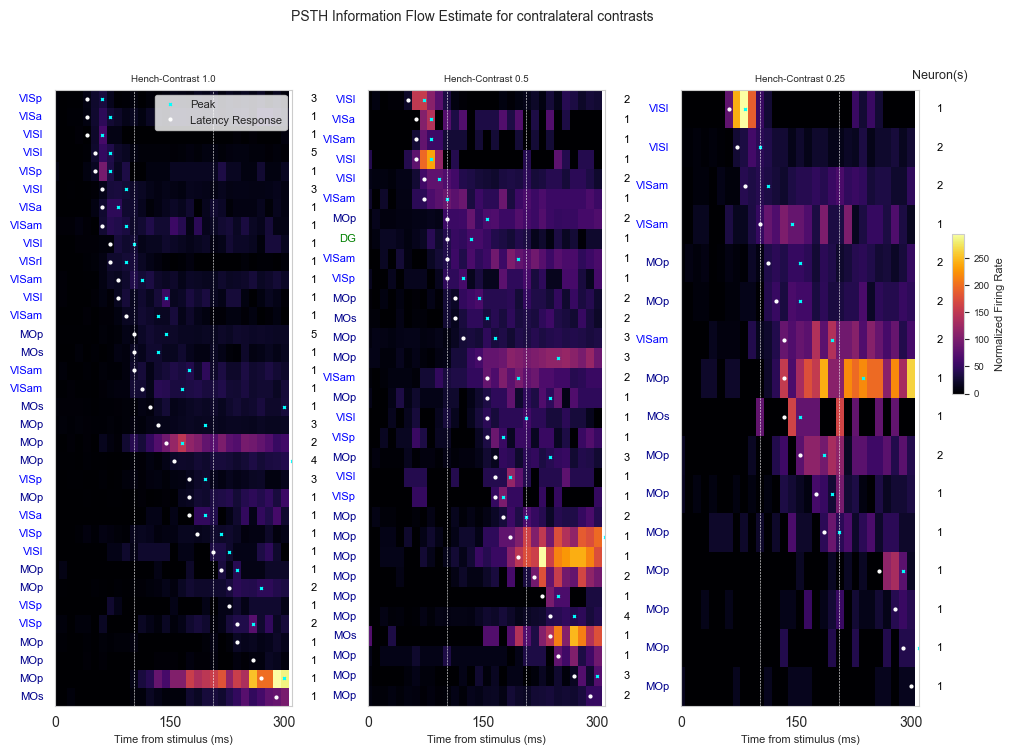

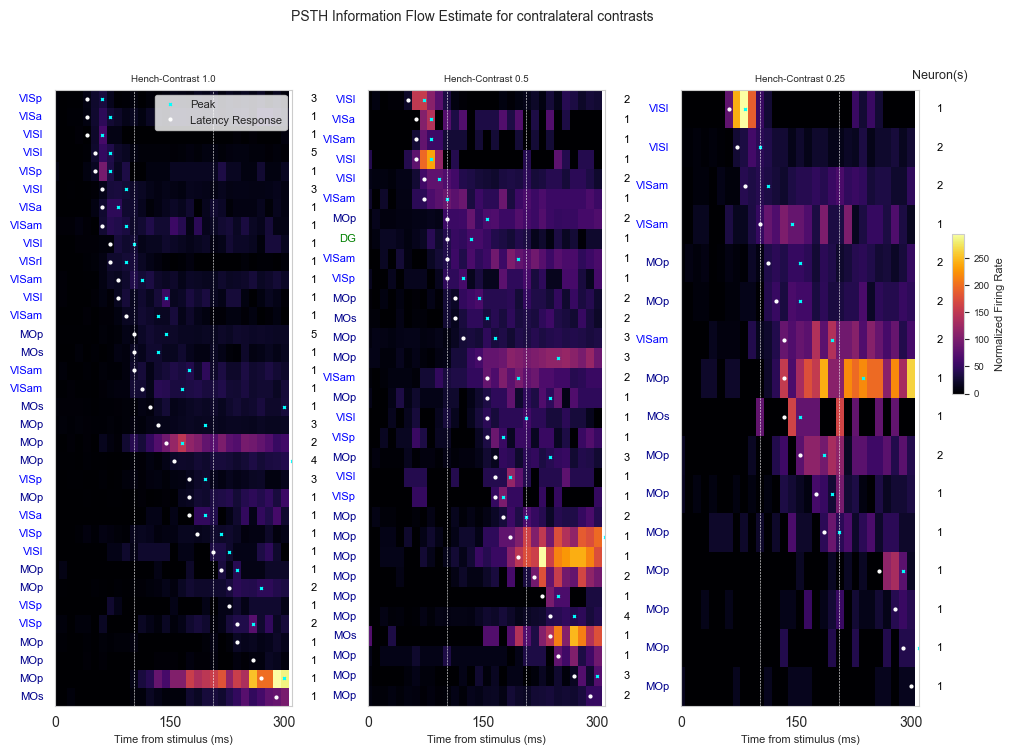

In [66]:
plot_psth_response_rank(exp_df,groups_of_interest,'Hench',"contralateral",'right_reward')